## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

## Clibrate  Camera
####  Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from math import atan2, ceil, pi
#%matplotlib inline

def camera_cali(img_path_list, num_x=6, num_y=9): 
    """
    Return cameraMatrix and distortion coefficients  
    :img_path_list: list of calibration jpeg file full path
    :num_x: the number of corners in any given row
    :num_y: the number of corners in any given column
    """ 
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    objp = np.zeros((num_x*num_y, 3), np.float32)
    objp[:,:2] = np.mgrid[0:num_x, 0:num_y].T.reshape(-1, 2)
    for img_path in img_path_list:
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (num_x, num_y), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    img_size = (gray.shape[1], gray.shape[0])
    ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return mtx, dist

# get the calibration image path list
cal_images = glob.glob('camera_cal/calibration*.jpg')
print("number of test images:", len(cal_images))
MTX, DIST = camera_cali(cal_images)


number of test images: 20


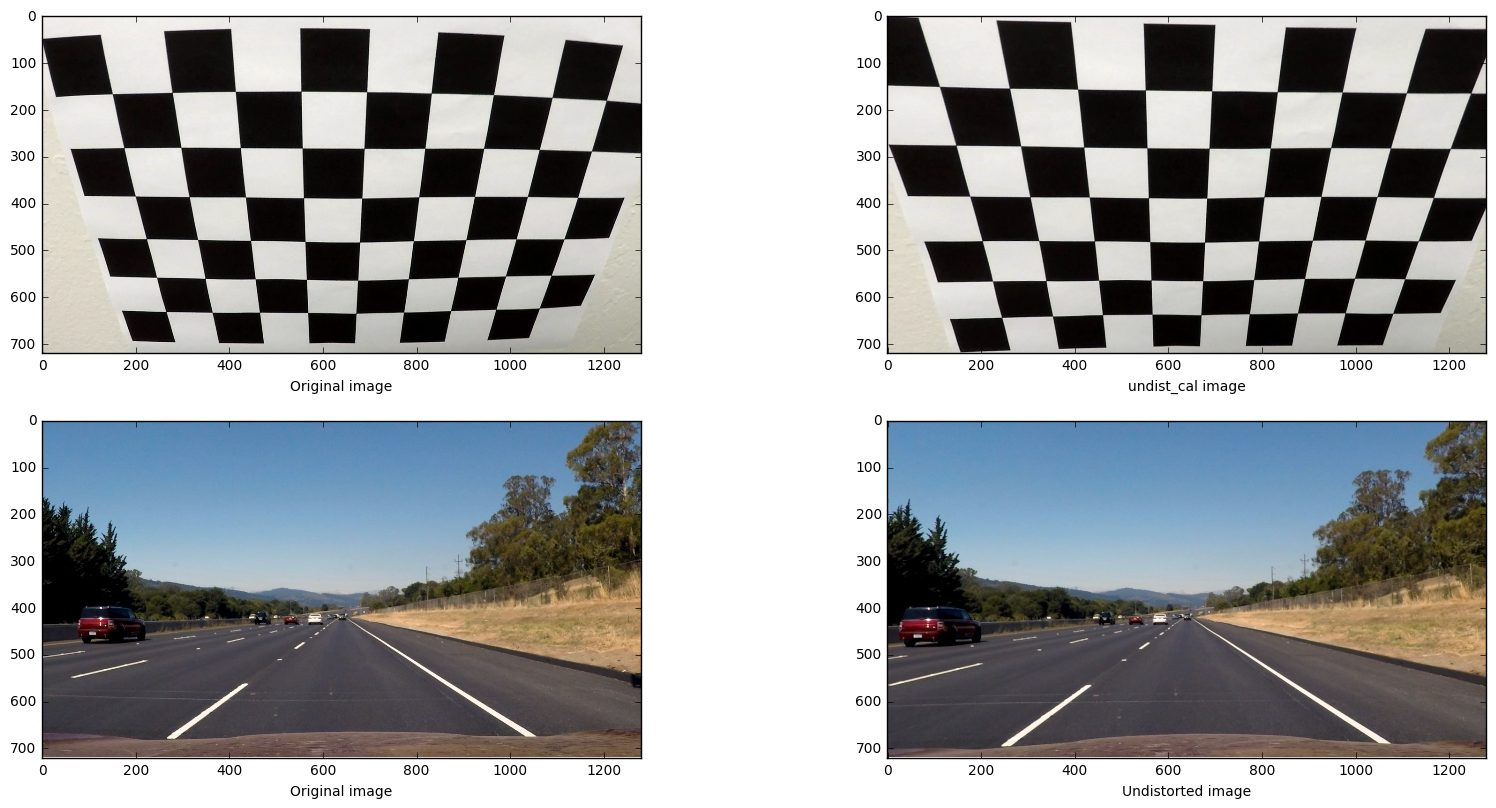

In [2]:
################################
# vefriy the Camera Calibration 
################################

origin_cal_img = mpimage.imread('camera_cal/calibration2.jpg')
undist_cal = cv2.undistort(origin_cal_img, MTX, DIST, None, MTX)

origin_test_img = mpimage.imread('test_images/straight_lines2.jpg')
undist_test = cv2.undistort(origin_test_img, MTX, DIST, None, MTX)

plt.figure(figsize=(20,20))
plt.subplot(4, 2, 1)
plt.imshow(origin_cal_img)
plt.xlabel('Original image')

plt.subplot(4, 2, 2)
plt.imshow(undist_cal)
plt.xlabel('undist_cal image')

plt.subplot(4, 2, 3)
plt.imshow(origin_test_img)
plt.xlabel('Original image')

plt.subplot(4, 2, 4)
plt.imshow(undist_test)
plt.xlabel('Undistorted image')

plt.show()

## Color and Gradient Threshold

In [3]:
# calculates image derivatives using the Sobel operator.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == "x":
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == "y":
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

# function that applies Sobel x and y, 
# then computes the magnitude of the gradient: np.sqrt(np.square(sobelx)+np.square(sobely))
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), use_xy=False):
    if use_xy:
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=sobel_kernel)
        sobelxy = np.uint8(255*sobel/np.max(sobel))
    else:
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))
        sobelxy = np.uint8(255*sobelxy/np.max(sobelxy))

    mag_binary = np.zeros_like(sobelxy)
    mag_binary[(sobelxy>=mag_thresh[0])&(sobelxy<=mag_thresh[1])] = 1
    return mag_binary

# function that applies Sobel x and y, 
# then computes the direction of the gradient: np.arctan2(np.absolute(sobely), np.absolute(sobelx))
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

# function that thresholds the S-channel of HLS
def color_threshold(s_channel, s_thresh=(170, 255)):
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

# function to get the binary image which ideally has the lane edges only
def get_edges_binary(img, debug=False):
    """
    Return binary image of edges 
    :img: RGB image data
    :debug: optional the debug flag to enable plots or not
    """ 
    # convert RGB to HLS
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=ksize, thresh=(35, 255))
    grady = abs_sobel_thresh(l_channel, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    #mag_binary = mag_thresh(l_channel, sobel_kernel=ksize, mag_thresh=(30, 255))
    #dir_binary = dir_threshold(l_channel, sobel_kernel=ksize, thresh=(np.pi/2, np.pi/2)) #np.pi/2
    s_binary = color_threshold(s_channel)
    
    combined = np.zeros_like(gradx)
    # use sobelX sobelY and color threshold to get the final edges binary image
    combined[((gradx == 1) & (grady == 1)) | (s_binary == 1)] = 1
    if debug:
        plt.figure(figsize=(20,20))
        plt.subplot(7, 3, 1)
        plt.imshow(s_channel, cmap='gray')
        plt.xlabel('s_channel image')
        plt.subplot(7, 3, 2)
        plt.imshow(l_channel, cmap='gray')
        plt.xlabel('l_channel image')
        plt.subplot(7, 3, 3)
        plt.imshow(gradx, cmap='gray')
        plt.xlabel('gradx image')
        plt.subplot(7, 3, 4)
        plt.imshow(grady, cmap='gray')
        plt.xlabel('grady image')
        plt.subplot(7, 3, 5)
        plt.imshow(s_binary, cmap='gray')
        plt.xlabel('s_binary image')
        plt.subplot(7, 3, 6)
        plt.imshow(combined, cmap='gray')
        plt.xlabel('combine image')
        plt.show()
    
    return combined


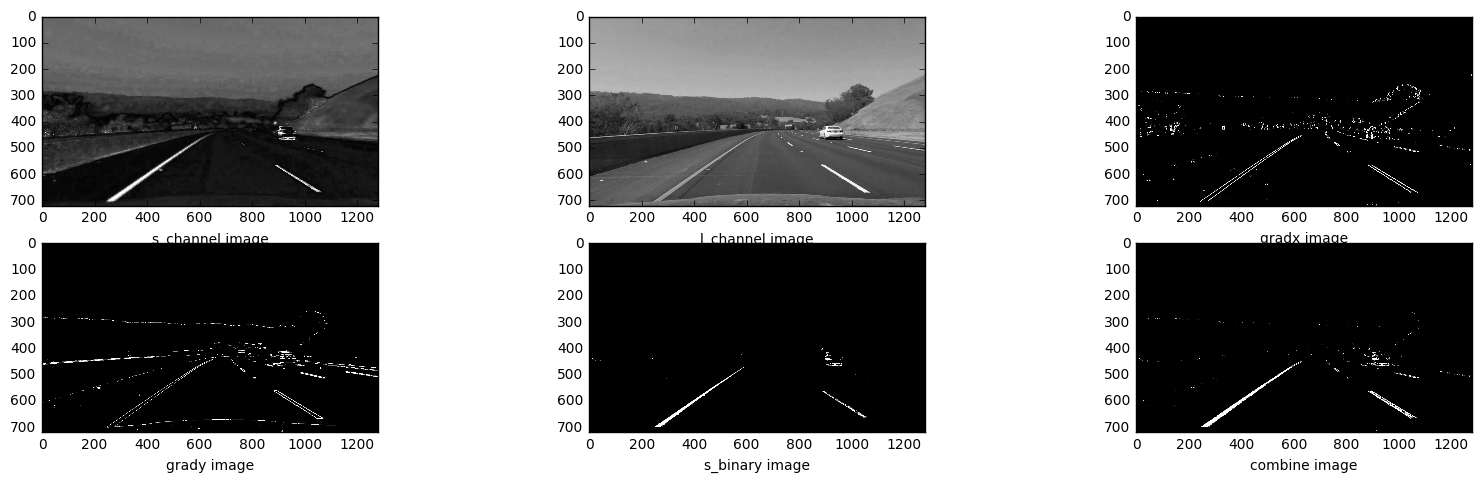

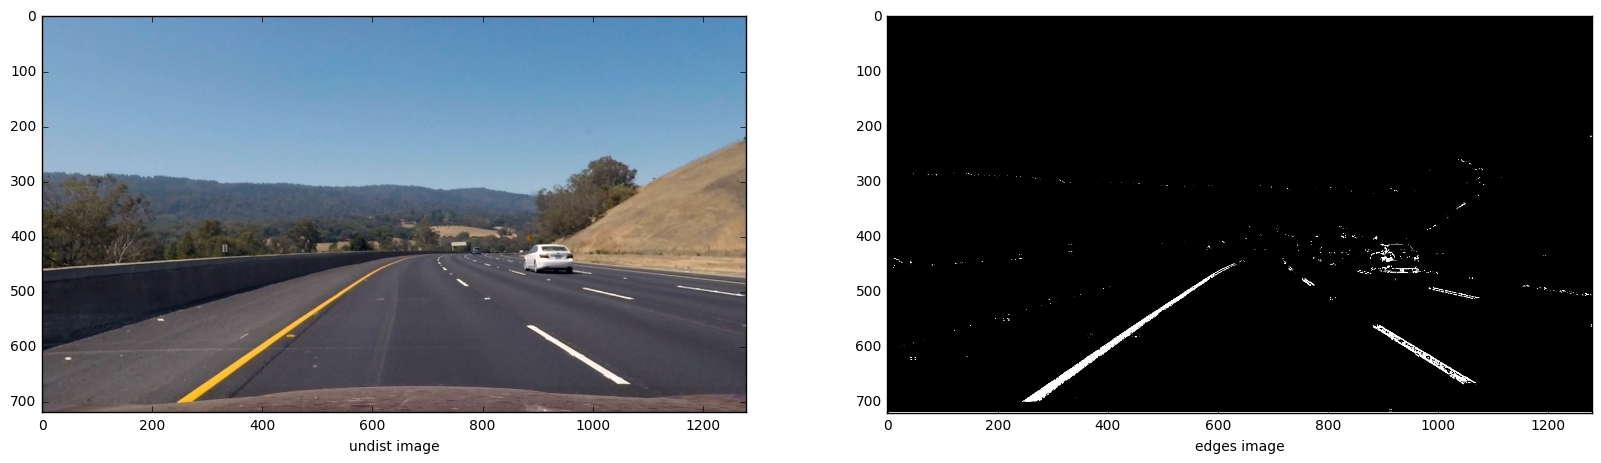

In [4]:
######################################
# Verify get_edges_binary() function
#####################################

test_img_path = "test_images/test3.jpg"
img_data = mpimage.imread(test_img_path)
test_undist_img = cv2.undistort(img_data, MTX, DIST, None, MTX)
test_edges_img = get_edges_binary(test_undist_img, debug=True)
plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1)
plt.imshow(test_undist_img )
plt.xlabel('undist image')
plt.subplot(2, 2, 2)
plt.imshow(test_edges_img, cmap='gray')
plt.xlabel('edges image')
plt.show()


In [5]:
from math import atan2, ceil, pi

# function to get four corners in the image to define a rectangle
# which will be used in get_perspective_transform() to get the transform matrix later
def get_perspective_points(edge_image):
    """
    Return src (four corner points) and roi_lines (points of the lane)
    :edge_image: binary image of edges
    """ 
    # distance resolution of the accumulator in pixels.
    rho = 2 
    # angle resolution of the accumulator in radians.
    theta = 0.5*np.pi/180
    # minimum line length. Line segments shorter than that are rejected.
    min_line_len = 100
    # maximum allowed gap between points on the same line to link them.
    max_line_gap = 190  
    # accumulator threshold parameter. Only those lines are returned that get enough votes ( >\texttt{threshold} ).
    threshold = 100  
    # minimum angle of atan2(y1-y2, x2-x1)
    min_angle = 20*pi/180
    # maximum angle of atan2(y1-y2, x2-x1)
    max_angle = 65*pi/180
    roi_edges = np.copy(edge_image)
    
    # ROI is from bottom to 0.65*image_height
    roi_edges[ : int(roi_edges.shape[0]*0.65), : ] = 0
    
    lines = cv2.HoughLinesP(roi_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)
    roi_lines = list()
    left_lane_points = list()
    right_lane_points = list()
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            # calculate radians
            radians = atan2(y1-y2, x2-x1)
            abs_rad = abs(radians)
            if abs_rad >= min_angle and abs_rad <= max_angle:
                roi_lines.append((x1, y1, x2, y2))
                if radians > 0:
                    left_lane_points.append((x1, y1))
                    left_lane_points.append((x2, y2))
                else:
                    right_lane_points.append((x1, y1))
                    right_lane_points.append((x2, y2))
    
    if not left_lane_points or not right_lane_points:
        return None
    
    left_lane_p  = np.polyfit([s[1] for s in left_lane_points], [s[0] for s in left_lane_points], 1)
    right_lane_p = np.polyfit([s[1] for s in right_lane_points], [s[0] for s in right_lane_points], 1)
    
    # the equation is ay+b=x -> ay-x=-b
    # so use np.linalg.solve to get the intersection
    intersection  = np.linalg.solve([[left_lane_p[0], -1], [right_lane_p[0], -1]], 
                                                     [-left_lane_p[1], -right_lane_p[1]])
    # top y is the intersection point 
    top_y = ceil(intersection[0] + roi_edges.shape[0] * 0.06)
    # bottom y is the image height value
    bottom_y = roi_edges.shape[0]
    
    top_left_x = ceil(np.polyval(left_lane_p, top_y))
    bottom_left_x = ceil(np.polyval(left_lane_p, bottom_y))
    
    top_right_x = ceil(np.polyval(right_lane_p, top_y))
    bottom_right_x = ceil(np.polyval(right_lane_p, bottom_y))
    
    src = np.float32([ [top_left_x, top_y], [top_right_x, top_y], 
                       [bottom_right_x, bottom_y], [bottom_left_x, bottom_y] ])

    return src, roi_lines
    


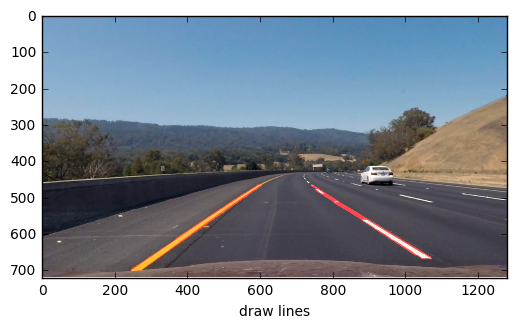

In [6]:
######################################
# Verify the get_perspective_points()
######################################
# Verify the lines
######################################
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    for x1, y1, x2, y2 in lines:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
def weighted_img(initial_img, img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

test_img_path = "test_images/test3.jpg"
# read camera image RGB data
img_data = mpimage.imread(test_img_path)
# undistort camera image
test_undist_img = cv2.undistort(img_data, MTX, DIST, None, MTX)
# get the lane-edges binary image
test_edges_img = get_edges_binary(test_undist_img, debug=False)

src, lines = get_perspective_points(test_edges_img)
line_img = np.zeros(test_undist_img.shape, dtype=np.uint8)
draw_lines(line_img, lines)
comb = weighted_img(line_img, test_undist_img)
plt.imshow(comb)
plt.xlabel('draw lines')
plt.show()
 

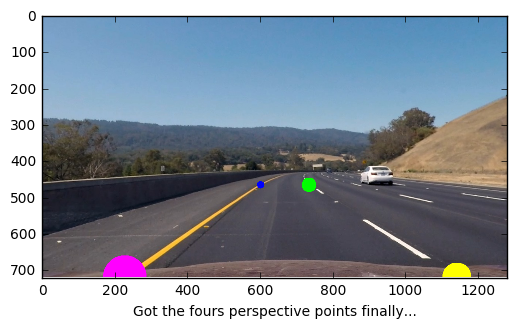

In [7]:
######################################
# Verify the get_perspective_points()
######################################
# Verify src points
######################################

top_left, top_right, bottom_right, bottom_left = src
img_cp = np.copy(test_undist_img)
# draw the src points
cv2.circle(img_cp, (top_left[0], top_left[1]), 10, (0,0,255), -1)
cv2.circle(img_cp, (top_right[0], top_right[1]), 20, (0,255,0), -1)
cv2.circle(img_cp, (bottom_right[0], bottom_right[1]), 40, (255,255,0), -1)
cv2.circle(img_cp, (bottom_left[0], bottom_left[1]), 60, (255,0,255), -1)
plt.imshow(img_cp)
plt.xlabel('Got the fours perspective points finally...')
plt.show()

In [8]:
# function to get the transform matrix M 
# which will be used for cv2.warpPerspective() to warp the image to a top-down view
# And reverse transform matrix M_revers
# which to warp the image from a top-down view to the normal driving view
def get_perspective_transform(img, src):
    """
    Return matrix M and reverse matrix M
    :img: RGB image data
    :src: four corners in the image to define a rectangle
    """ 
    default_width = 1280.0
    default_height = 720.0
    img_height, img_width, ch = img.shape
     
    width_ratio = img_width/default_width
    height_ratio = img_height/default_height
    dst = np.array([[300.0*width_ratio,  100.0*height_ratio],
                    [1000.0*width_ratio, 100.0*height_ratio],
                    [1000.0*width_ratio, 720.0*height_ratio],
                    [300.0*width_ratio, 720.0*height_ratio]], np.float32)
    m = cv2.getPerspectiveTransform(src, dst)
    m_reverse = cv2.getPerspectiveTransform(dst, src)
    return m, m_reverse


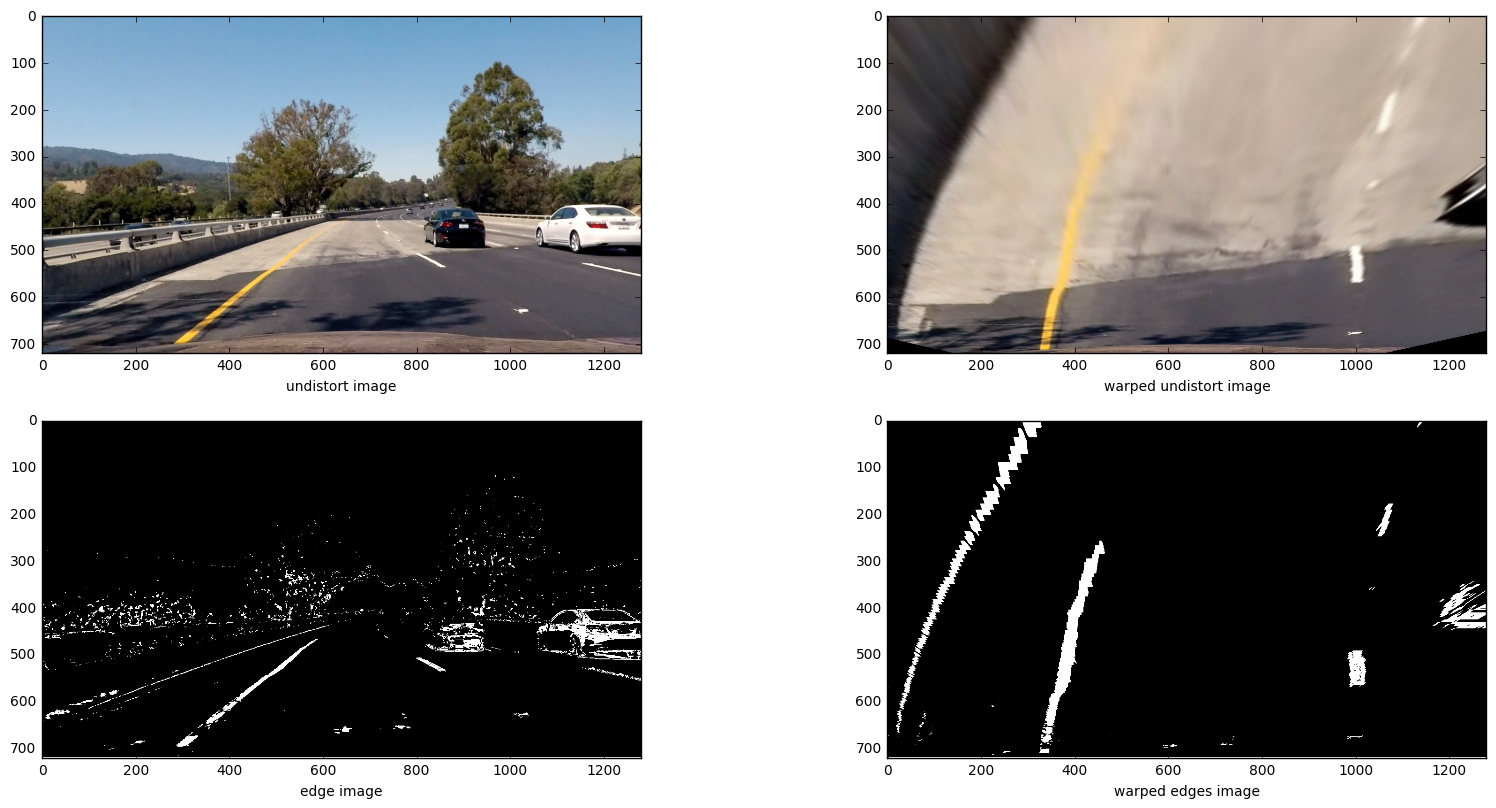

In [9]:
##################################################
# Verify the feature get_perspective_transform()
##################################################

test_img_path = "test_images/test4.jpg"
img_data = mpimage.imread(test_img_path)
test_undist_img = cv2.undistort(img_data, MTX, DIST, None, MTX)
test_edges_img = get_edges_binary(test_undist_img, debug=False)
# get four src points
src, _ = get_perspective_points(test_edges_img)
# get transform matrix M  
m, m_reverse = get_perspective_transform(test_undist_img, src)

# applies a perspective transformation to the undistort image.
test_warp_undist_img = cv2.warpPerspective(test_undist_img, m, (test_undist_img.shape[1], test_undist_img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)

test_warp_edges_img = cv2.warpPerspective(test_edges_img, m, (test_undist_img.shape[1], test_undist_img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)
 
plt.figure(figsize=(20,20))
plt.subplot(4, 2, 1)
plt.imshow(test_undist_img)
plt.xlabel('undistort image')
plt.subplot(4, 2, 2)
plt.imshow(test_warp_undist_img)
plt.xlabel('warped undistort image')
plt.subplot(4, 2, 3)
plt.imshow(test_edges_img, cmap='gray')
plt.xlabel('edge image')
plt.subplot(4, 2, 4)
plt.imshow(test_warp_edges_img, cmap='gray')
plt.xlabel('warped edges image')
plt.show()

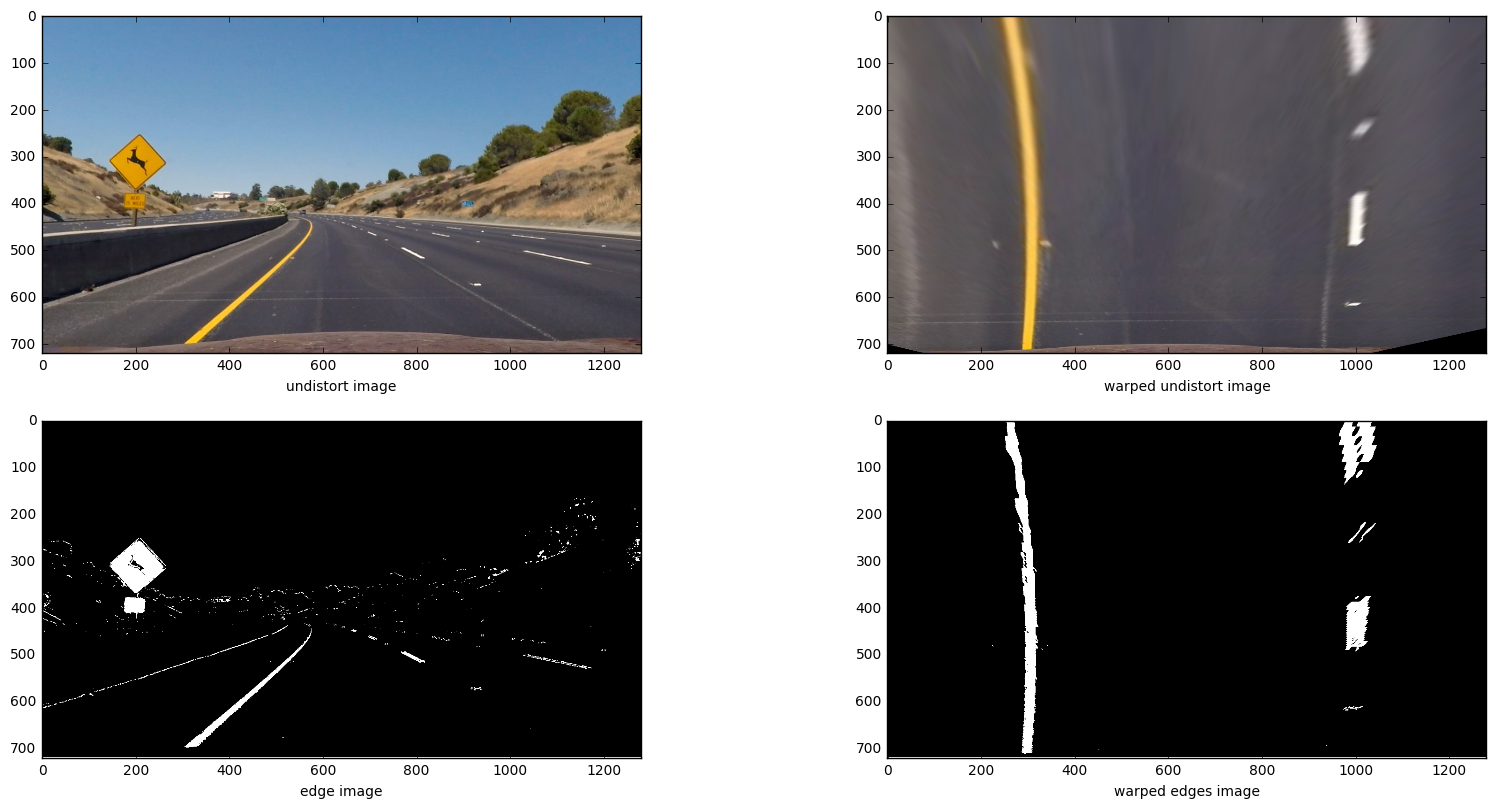

In [10]:
##################################################
# Verify the feature get_perspective_transform()
##################################################
# Use another camera test image
##################################################
test_img_path = "test_images/test2.jpg"
img_data = mpimage.imread(test_img_path)
test_undist_img = cv2.undistort(img_data, MTX, DIST, None, MTX)
test_edges_img = get_edges_binary(test_undist_img, debug=False)
src, lines = get_perspective_points(test_edges_img)
m, m_reverse = get_perspective_transform(test_undist_img, src)

test_warp_undist_img = cv2.warpPerspective(test_undist_img, m, (test_undist_img.shape[1], test_undist_img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)

test_warp_edges_img = cv2.warpPerspective(test_edges_img, m, (test_undist_img.shape[1], test_undist_img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)
 
plt.figure(figsize=(20,20))
plt.subplot(4, 2, 1)
plt.imshow(test_undist_img)
plt.xlabel('undistort image')
plt.subplot(4, 2, 2)
plt.imshow(test_warp_undist_img)
plt.xlabel('warped undistort image')
plt.subplot(4, 2, 3)
plt.imshow(test_edges_img, cmap='gray')
plt.xlabel('edge image')
plt.subplot(4, 2, 4)
plt.imshow(test_warp_edges_img, cmap='gray')
plt.xlabel('warped edges image')
plt.show()

In [11]:
from scipy.signal import find_peaks_cwt
# function to get the left lane and right lane base points by using histogram
# http://stackoverflow.com/questions/25571260/scipy-signal-find-peaks-cwt-not-finding-the-peaks-accurately
def find_base_points(warped_edges_img):
    """
    Return [left_base_point, right_base_point] and histogram data
    :warped_edges_img: warped edges binary image
    """ 
    height, width = warped_edges_img.shape[0:2]
    # only search the half bottom of the image
    histogram = np.sum(warped_edges_img[int(height/2):, :], axis=0)
    peak_width = [50]
    min_num_peak_pt = 20
    # indices of peak points
    idx = find_peaks_cwt(histogram, peak_width, max_distances=peak_width) 
    if len(idx) < 2:
        return None
    # drop the points from the image border (width*0.15)
    idx = [i for i in idx if i > width*0.15 and i < width*0.85
            and max(histogram[i-50: i+50]) > min_num_peak_pt]        
 
    return [min(idx), max(idx)], histogram


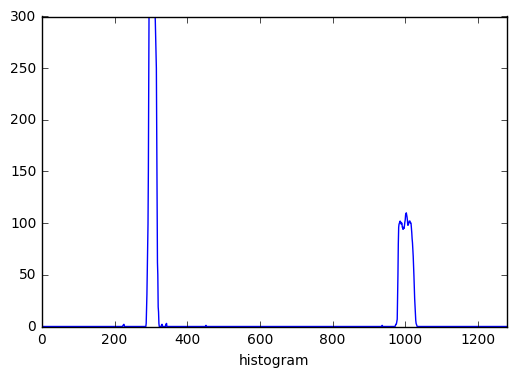

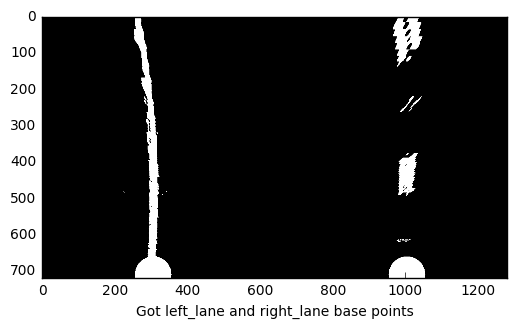

In [12]:
############################
# Verify find_base_points()
############################

test_img_path = "test_images/test2.jpg"
img_data = mpimage.imread(test_img_path)
test_undist_img = cv2.undistort(img_data, MTX, DIST, None, MTX)
test_edges_img = get_edges_binary(test_undist_img, debug=False)
src, lines = get_perspective_points(test_edges_img)
m, m_reverse = get_perspective_transform(test_undist_img, src)

test_warp_undist_img = cv2.warpPerspective(test_undist_img, m, (test_undist_img.shape[1], test_undist_img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)

test_warp_edges_img = cv2.warpPerspective(test_edges_img, m, (test_undist_img.shape[1], test_undist_img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)

test_base_pts, test_hist = find_base_points(test_warp_edges_img)

plt.plot(test_hist)
plt.ylim([0, 300])
plt.xlim([0, 1280])
plt.xlabel('histogram')
plt.show()

left_pt_x, right_pt_x = test_base_pts
img_cp = np.copy(test_warp_edges_img)
cv2.circle(img_cp, (left_pt_x, 720-10), 50, (1,1,1), -1)
cv2.circle(img_cp, (right_pt_x, 720-10), 50, (1,1,1), -1)
plt.imshow(img_cp, cmap='gray')
plt.xlabel('Got left_lane and right_lane base points')
plt.show()

In [13]:
# drop some outliers (line points) to make sure to get the accurate ployfit
def drop_outliers(x_list, y_list):
    if not x_list or not y_list:
        return x_list, y_list
    mu_x, mu_y = np.mean(x_list), np.mean(y_list)
    #std = sqrt(mean(abs(x - x.mean())**2)).
    sig_x, sig_y = np.std(x_list), np.std(y_list)
    new_x, new_y = zip(*[(x, y) for (x,y) in zip(x_list, y_list) 
                       if abs(x - mu_x) < 2*sig_x and abs(y - mu_y) < 2*sig_y])
    return new_x, new_y

# function for Sliding Window Search
def find_lanes_points(warped_edges_img, base_pts, num_slides=10, slide_window_width_ratio=0.2):
    """
    return the numpy array of left_lane_x, left_lane_y, right_lane_x and right_lane_y
    :warped_edges_img: warped edges binary image data 
    :base_pts: (left_lane_base_points, right_lane_base_points)
    :num_slides: num of horizontal slides
    :slide_window_width_ratio: define the width of the sliding window
    """
    height, width = warped_edges_img.shape[0:2]
    slide_height = int(height/num_slides)
    half_window_width = int(slide_window_width_ratio*width/2)
    
    l_x, l_y = [], []
    r_x, r_y = [], [] 
    base_left_x, base_right_x = base_pts
    idx_left_x, idx_right_x = base_pts
    # move the sliding window from bottom to top
    for i in range(num_slides-1, -1, -1):
        left_check_window = warped_edges_img[i*slide_height : (i+1)*slide_height, 
                            base_left_x - half_window_width : base_left_x + half_window_width]
        right_check_window = warped_edges_img[i*slide_height : (i+1)*slide_height, 
                            base_right_x - half_window_width : base_right_x + half_window_width]
        # get the indices of the elements that are non-zero.
        left_y_pts, left_x_pts = np.nonzero(left_check_window)
        right_y_pts, right_x_pts = np.nonzero(right_check_window)
        
        l_x.extend(left_x_pts + (base_left_x - half_window_width))
        l_y.extend(left_y_pts + i*slide_height)
        r_x.extend(right_x_pts + (base_right_x - half_window_width))
        r_y.extend(right_y_pts + i*slide_height)

        # sum Colums to find x who has max nonzero elements as the baseline for next window
        col_sum_left = np.sum(left_check_window, axis=0)
        col_sum_right = np.sum(right_check_window, axis=0)
        if np.any(col_sum_left > 0):
            base_left_x = np.argmax(col_sum_left) + base_left_x - half_window_width
        if np.any(col_sum_right > 0):
            base_right_x = np.argmax(col_sum_right) + base_right_x - half_window_width
    
    # drop outliers
    left_x, left_y = drop_outliers(l_x, l_y)
    right_x, right_y = drop_outliers(r_x, r_y)
    return np.array(left_x), np.array(left_y), np.array(right_x), np.array(right_y)


# a helper function to calculate the polynomial curve fitting 
def get_curve(xvals, yvals):
    lane_fit_cr = np.polyfit(yvals, xvals, 2)
    return lane_fit_cr


# a helper function to calculate the radius of curvature and the car position
def get_curve_rad_and_position(left_x, right_x, yvals, img_width):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(yvals)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(yvals*ym_per_pix, xm_per_pix*left_x, 2)
    right_fit_cr = np.polyfit(yvals*ym_per_pix, xm_per_pix*right_x, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    middle = (left_fitx[-1] + right_fitx[-1])//2
    img_mid = img_width//2
    # position value positive if on the right, negative on the left
    position = (img_mid - middle)*xm_per_pix 
    return left_curverad, right_curverad, position
     

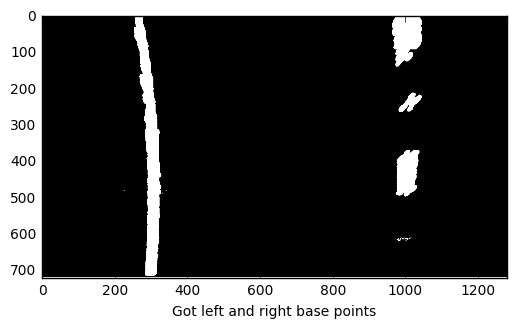

In [14]:
#############################
# Verify find_lanes_points() 
#############################

test_img_path = "test_images/test2.jpg"
# read image RGB data
img_data = mpimage.imread(test_img_path)
# undistort image
test_undist_img = cv2.undistort(img_data, MTX, DIST, None, MTX)
# get edges binary image
test_edges_img = get_edges_binary(test_undist_img, debug=False)
# get src points which will be used for warping the image 
src, lines = get_perspective_points(test_edges_img)
# get transform matrix m and reverse transform matrix m_reverse    
m, m_reverse = get_perspective_transform(test_undist_img, src)
# warp undistort image to top-down review
test_warp_undist_img = cv2.warpPerspective(test_undist_img, m, (test_undist_img.shape[1], test_undist_img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)

test_warp_edges_img = cv2.warpPerspective(test_edges_img, m, (test_undist_img.shape[1], test_undist_img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)

# find left_lane base point and right_lane base point
test_base_pts, _ = find_base_points(test_warp_edges_img)
# find points on the left_lane and right_lane
left_x, left_y, right_x, right_y = find_lanes_points(test_warp_edges_img, test_base_pts)

img_cp = np.copy(test_warp_edges_img)

for x, y in zip(left_x, left_y):
    cv2.circle(img_cp, (x, y), 5, (1,1,1), -1)
for x, y in zip(right_x, right_y):
    cv2.circle(img_cp, (x, y), 5, (1,1,1), -1)
plt.imshow(img_cp, cmap='gray')
plt.xlabel('Got left and right base points')
plt.show()


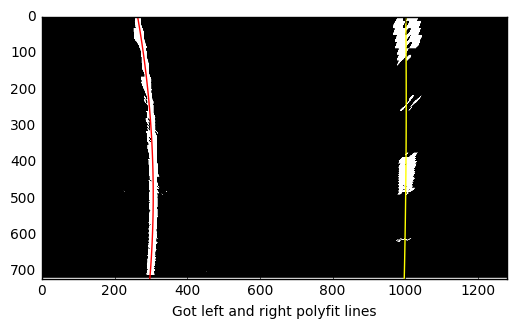

In [15]:
######################################
# Verify find_lanes_points() 
######################################
# Use the points to calculate ployfit
######################################

left_fit_cr = get_curve(left_x, left_y)
right_fit_cr = get_curve(right_x, right_y)
test_yvals = np.linspace(0, test_warp_edges_img.shape[0], 100, dtype=int)
left_fitx = left_fit_cr[0]*test_yvals**2 + left_fit_cr[1]*test_yvals + left_fit_cr[2]
right_fitx = right_fit_cr[0]*test_yvals**2 + right_fit_cr[1]*test_yvals + right_fit_cr[2]

img_cp = np.copy(test_warp_edges_img)
plt.imshow(img_cp, cmap='gray')
plt.xlabel('Got left and right polyfit lines')
plt.plot(left_fitx, test_yvals, color='red',)
plt.plot(right_fitx, test_yvals, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [16]:
# function to draw the lines back down onto the road  
def gen_final_output(undist_img, warp_undist_img, warp_minv, left_fitx, right_fitx, yvals):
    """
    return the final image with clear lane boundaries 
    :undist_img: undistort image RGB data
    :warp_undist_img: warped undistort image RGB data
    :warp_minv: transform matrix to warp undistort image to original image
    :left_fitx: x values of left lane
    :right_fitx: x values of right lane
    :yvals: y valuse
    """
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warp_undist_img).astype(np.uint8)
    
    left_pts = np.column_stack((left_fitx, yvals))
    left_pts = np.int32(left_pts)
    left_pts = left_pts.reshape(-1,1,2)

    right_pts = np.column_stack((right_fitx, yvals))
    right_pts = np.int32(right_pts)
    right_pts = right_pts.reshape(-1,1,2)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_undist_img, np.int_([pts]), (0,255, 0))
    cv2.drawContours(warp_undist_img, left_pts, -1, (255,0,0), thickness=25)
    cv2.drawContours(warp_undist_img, right_pts, -1, (255,0,0), thickness=25)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_undist_img, warp_minv, (warp_undist_img.shape[1], warp_undist_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    return result
    

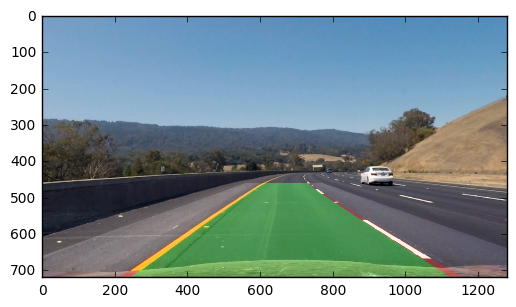

(2698.0713435552952, 1954.0265659885663, -0.052857142857142859)

In [17]:
############################
# verify gen_final_output()
############################
test_img_path = "test_images/test3.jpg"
img_data = mpimage.imread(test_img_path)
test_undist_img = cv2.undistort(img_data, MTX, DIST, None, MTX)
test_edges_img = get_edges_binary(test_undist_img, debug=False)
src, lines = get_perspective_points(test_edges_img)
m, warp_minv = get_perspective_transform(test_undist_img, src)

test_warp_undist_img = cv2.warpPerspective(test_undist_img, m, (test_undist_img.shape[1], test_undist_img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)

test_warp_edges_img = cv2.warpPerspective(test_edges_img, m, (test_undist_img.shape[1], test_undist_img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)

test_base_pts, _ = find_base_points(test_warp_edges_img)

left_x, left_y, right_x, right_y = find_lanes_points(test_warp_edges_img, test_base_pts)
left_fit_cr = get_curve(left_x, left_y)
right_fit_cr = get_curve(right_x, right_y)
test_yvals = np.linspace(0, test_warp_edges_img.shape[0], 100, dtype=int)
left_fitx = left_fit_cr[0]*test_yvals**2 + left_fit_cr[1]*test_yvals + left_fit_cr[2]
right_fitx = right_fit_cr[0]*test_yvals**2 + right_fit_cr[1]*test_yvals + right_fit_cr[2]

result = gen_final_output(test_undist_img, test_warp_undist_img, warp_minv, left_fitx, right_fitx, test_yvals)
plt.imshow(result)
plt.show()
get_curve_rad_and_position(left_fitx, right_fitx, test_yvals, test_warp_edges_img.shape[1])

In [18]:
# function to find the lane points from known ployfit
def get_lane_from_known_fit(warped_edge, left_fit, right_fit):
    """
    return new left_lane polyfit and right_lane ployfit
    :left_fit: left_lane polyfit
    :right_fit: right_lane polyfit
    """
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = warped_edge.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 55
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
     
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    #print(type(lefty), type(leftx))
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit
    

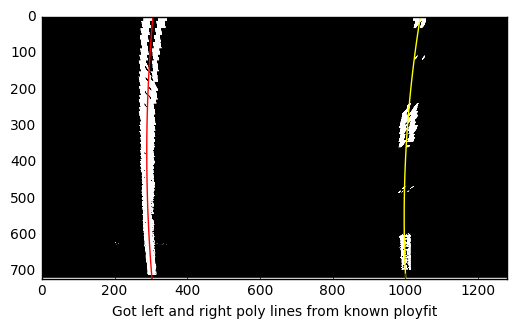

In [19]:
###################################
# Verify get_lane_from_known_fit()
###################################

left_fit, right_fit = get_lane_from_known_fit(test_warp_edges_img, left_fit_cr, right_fit_cr)
yvals = np.linspace(0, test_warp_edges_img.shape[0], 100, dtype=int)
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

img_cp = np.copy(test_warp_edges_img)
plt.imshow(img_cp, cmap='gray')
plt.xlabel('Got left and right poly lines from known ployfit')
plt.plot(left_fitx, yvals, color='red')
plt.plot(right_fitx, yvals, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [20]:
class Line():
    def __init__(self, img_height):
        # y values are fixed
        self.fixed_yvals = np.linspace(0, img_height, 100, dtype=int)
        self.y_eval = np.max(self.fixed_yvals)
        # was the line detected in the last iteration?
        self.detected = False  
        # number of times of failed lane detection
        self.failed_detection = 0
        # x values of the previous successful fits of the line
        self.recent_fitx = None
        # previous successful fits of the line
        self.recent_polyfit = None
        # radius of curvature of the line
        self.radius_of_curvature = None 
    
    # update the ployfit of the line if self.detected is True
    def update_curve_polyfit(self, xvals, yvals, reset=False):
        # combine the recent fitx with the new ones when reset flag set to True
        # to smooth measurement
        if self.recent_fitx is not None and reset:
            xvals = np.append(xvals, self.recent_fitx)
            yvals = np.append(yvals, self.fixed_yvals)
        current_curv_fit = np.polyfit(yvals, xvals, 2)  
        curve_rad, current_fitx = self.get_real_curve_rad(current_curv_fit)
        self.detected = self.is_detected(curve_rad)
        if not self.detected:
            self.failed_detection += 1
        else:
            self.failed_detection = 0
            self.recent_polyfit = current_curv_fit
            self.recent_fitx = current_fitx
            self.radius_of_curvature = curve_rad
    
    #calculate the rad of curvature in real world
    def get_real_curve_rad(self, curv_fit):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        current_fitx = curv_fit[0]*self.fixed_yvals**2 + curv_fit[1]*self.fixed_yvals + curv_fit[2]
        # Fit new polynomials to x,y in world space
        real_curv_fit = np.polyfit(ym_per_pix*self.fixed_yvals, xm_per_pix*current_fitx, 2)
        # Calculate the new rad of curvature
        curverad = ((1 + (2*real_curv_fit[0]*self.y_eval + real_curv_fit[1])**2)**1.5) / np.absolute(2*real_curv_fit[0])
        #print(curverad)
        return curverad, current_fitx 
    
    # detection failed if (current_radius_of_curvature/previsou_radius_of_curvature) > 2.0
    def is_detected(self, current_curve_rad):
        if self.radius_of_curvature is None:
            return True
        return abs(current_curve_rad/self.radius_of_curvature) <= 2.0


    

In [21]:
# dictionary to store the useful information for image processing
cache_dict = {'warp_m': None,
         'warp_minv': None,
         'base_points': None,
         'left_line': None,
         'right_line': None}

# main feature to process each frame from the video
def process_image(image, cache=cache_dict):
    # line object for left_line
    left_line = cache['left_line']
    # line object for right_line
    right_line = cache['right_line']
    # transform matrix warp_m to warp the image
    warp_m = cache['warp_m']
    # reverse transform matrix warp_minv  
    warp_minv = cache['warp_minv']
    # base points of lef_line and right_line
    base_points = cache['base_points']
    # image height and width
    img_height, img_width = image.shape[0:2]
    # y values from 0 to img_height, amount is 100
    fixed_yvals = np.linspace(0, img_height, 100, dtype=int)
    
    if left_line is None or right_line is None:
        left_line = Line(img_height)
        right_line = Line(img_height)
        
    # undistort image
    undist_image = cv2.undistort(image, MTX, DIST, None, MTX)
    # get egdes binary image
    edges_binary = get_edges_binary(undist_image)
   
    if warp_m is None or warp_minv is None:
        # get four corners in the image to define a rectangle
        src, _ = get_perspective_points(edges_binary)
        # get transform matrix warp_m and reverse transform matrix warp_minv to warp the image later
        warp_m, warp_minv = get_perspective_transform(undist_image, src)
        if src is not None:
            cache['warp_m'] = warp_m
            cache['warp_minv'] = warp_minv
    # warp undistort image which will be used in gen_final_output() later
    warpped_img = cv2.warpPerspective(undist_image, warp_m, (img_width, img_height), 
                                   flags=cv2.INTER_LINEAR)
    # warp undistort egdes binary image
    warpped_edges = cv2.warpPerspective(edges_binary, warp_m, (img_width, img_height), 
                                      flags=cv2.INTER_LINEAR)
    if base_points is None:
        # get left_line and right_line base points
        base_points, _ = find_base_points(warpped_edges)
        cache['base_points'] = base_points 
    
    # redo the blind search if failed_detection > 25 (1 seconds)
    if (left_line.recent_fitx is None or left_line.failed_detection > 25) or \
    (right_line.recent_fitx is None or right_line.failed_detection > 25):
        print("Reset!!")
        left_line.recent_fitx = None
        right_line.recent_fitx = None
        left_line.radius_of_curvature = None
        right_line.radius_of_curvature = None
        
        left_x, left_y, right_x, right_y = find_lanes_points(warpped_edges, base_points)
        left_line.update_curve_polyfit(left_x, left_y, reset=True)
        right_line.update_curve_polyfit(right_x, right_y, reset=True)
    else:
        # use the existing ployfit to find the lines
        left_fit, right_fit = get_lane_from_known_fit(warpped_edges, 
                                                      left_line.recent_polyfit, right_line.recent_polyfit)
         
        left_fitx = left_fit[0]*fixed_yvals**2 + left_fit[1]*fixed_yvals + left_fit[2]
        right_fitx = right_fit[0]*fixed_yvals**2 + right_fit[1]*fixed_yvals + right_fit[2]
        left_line.update_curve_polyfit(left_fitx, fixed_yvals)
        right_line.update_curve_polyfit(right_fitx, fixed_yvals)
    
    # genrate the output finally... 
    result_image = gen_final_output(undist_image, warpped_img, warp_minv, left_line.recent_fitx, 
                                right_line.recent_fitx, fixed_yvals)
    
    # calculate the car position
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    middle = (left_line.recent_fitx[-1] + right_line.recent_fitx[-1])//2
    img_mid = img_width//2
    position = (img_mid - middle)*xm_per_pix # Positive if on right, Negative on left
    
    # draw the curvature info and car position info on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result_image,'left  lane radius of curvature: %.1f m'%(left_line.radius_of_curvature),(50,50), 
                font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result_image,'right lane radius of curvature: %.1f m'%(right_line.radius_of_curvature),(50,80), font, 
                1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result_image,'car position: %.2f m %s of center'%(abs(position), 'right' if position > 0 else 'left'),
                (50,120), font, 1,(255,255,255),2,cv2.LINE_AA)

    cache['left_line'] = left_line
    cache['right_line'] = right_line
    
    return result_image

Reset!!


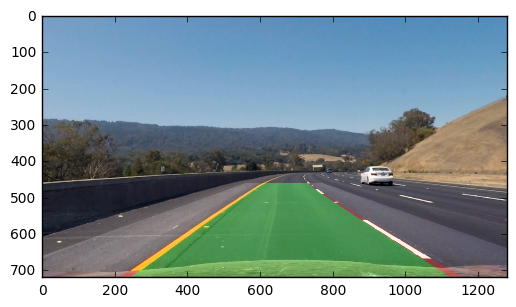

In [22]:
test_cache_dict = {'warp_m': None,
         'warp_minv': None,
         'base_points': None,
         'left_line': None,
         'right_line': None}

test_img_path = "test_images/test2.jpg"
img = mpimage.imread(test_img_path)
result_img = process_image(img, test_cache_dict)
plt.imshow(result)
plt.show()

In [23]:
from moviepy.editor import VideoFileClip
result_movie = 'project_video_draw_lines.mp4'
clip = VideoFileClip('project_video.mp4')
vid_clip = clip.fl_image(process_image)
vid_clip.write_videofile(result_movie, audio=False)

Reset!!
[MoviePy] >>>> Building video project_video_draw_lines.mp4
[MoviePy] Writing video project_video_draw_lines.mp4


100%|█████████▉| 1260/1261 [03:55<00:00,  5.75it/s]    | 1/1261 [00:00<05:21,  3.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_draw_lines.mp4 



In [24]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(result_movie))